This notebook is a demonstration of how tobac handles merging and splitting of features in the linking process

In [82]:
import tobac
import numpy as np
import matplotlib.pyplot as plt

In [83]:
def wandering_blob(x_0, y_0, x_min, y_min, x_max, y_max, v_x, v_y, t_max):
    
    x = np.linspace(x_min, x_max, 50)
    y = np.linspace(y_min, y_max, 50)
    t = np.linspace(0, t_max, 20)
    tt, yy, xx = np.meshgrid(t, y, x, indexing='ij')

    exponent = (xx - x_0 - v_x*tt)**2 + (yy - y_0 - v_y*tt)**2
    
    blob = np.exp(-exponent)
    
    return blob

In [84]:
blob = wandering_blob(0, 0, 0, 0, 10, 10, 1, 1, 10) + wandering_blob(10, 0, 0, 0, 10, 10, -1, 1, 10)

<IPython.core.display.Javascript object>


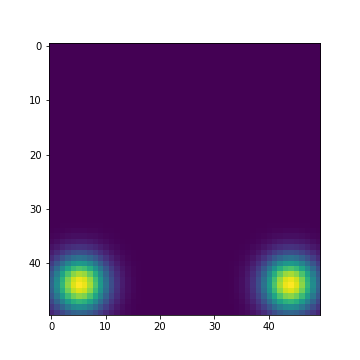

In [115]:
import matplotlib.animation as animation
%matplotlib notebook

fig, ax = plt.subplots(figsize = (5, 5))

def animate(i):
    plt.imshow(blob[i])
    
animation.FuncAnimation(fig, animate, frames = np.arange(0, 50, 1), interval = 100)

In [86]:
import datetime
import xarray as xr

def create_xarray(array):

    t_0 = np.datetime64('2022-04-01T00:00')
    t_delta = np.timedelta64(1, 'm')
    time = np.array([t_0 + i*t_delta for i in range(len(array))])
    x = np.linspace(0, 10, 50)
    y = np.linspace(0, 10, 50)
    latitude = np.linspace(20, 30, 50)
    longitude = np.linspace(40, 50, 50)
    
    coords = {'time':time,
             'projection_x_coordinate':x,
             'projection_y_coordinate':y}
    
    dims = {'latitude':latitude,
           'longitude':longitude}
    
    attributes = {'units': 'm s-1'}
    
    data = xr.DataArray(data=array, 
                        coords=coords,  
                        attrs=attributes)
    return data

In [87]:
%%capture
data = create_xarray(blob)
dxy, dt = tobac.utils.get_spacings(data, grid_spacing = 1)
features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, threshold=0.5)

<IPython.core.display.Javascript object>


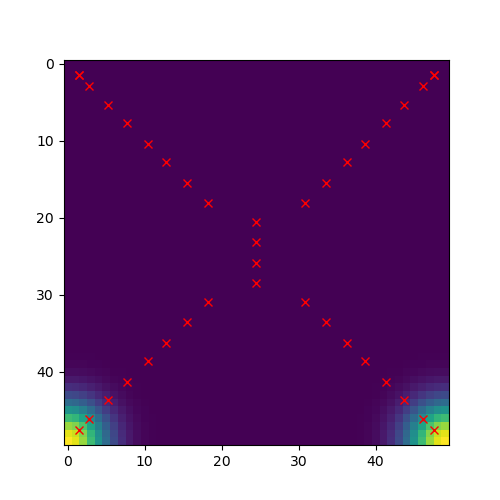

In [88]:
import matplotlib.animation as animation
%matplotlib notebook

fig, ax = plt.subplots(figsize = (5, 5))

def animate(i):
    plt.imshow(blob[i])
    mask = features['frame'] == i
    plt.plot(features.where(mask)['hdim_2'], features.where(mask)['hdim_1'], 'rx')
    
animation.FuncAnimation(fig, animate, frames = np.arange(0, 50, 1), interval = 100)

In [89]:
%%capture
mask, features = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=0.5)

<IPython.core.display.Javascript object>


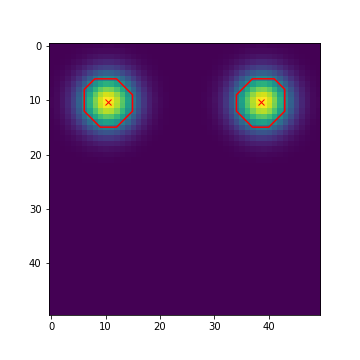

In [112]:
import matplotlib.animation as animation
%matplotlib notebook

fig, ax = plt.subplots(figsize = (5, 5))

def animate(i):
    plt.clf()
    plt.imshow(blob[i])
    plt.contour(mask[i], levels = [0.5], colors = 'red')
    mask_i = features['frame'] == i
    plt.plot(features.where(mask_i)['hdim_2'], features.where(mask_i)['hdim_1'], 'rx')
    
animation.FuncAnimation(fig, animate, frames = np.arange(0, 50, 1), interval = 500)

In [113]:
track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt, dxy, v_max = 1e20)

Frame 19: 2 trajectories present.


<IPython.core.display.Javascript object>


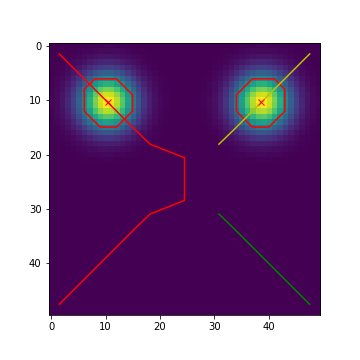

In [114]:
import matplotlib.animation as animation
%matplotlib notebook

fig, ax = plt.subplots(figsize = (5, 5))

def animate(i):
    plt.clf()
    plt.imshow(blob[i])
    plt.contour(mask[i], levels = [0.5], colors = 'red')

    track_mask_1 = track['cell'] == 1
    track_mask_2 = track['cell'] == 2
    track_mask_3 = track['cell'] == 3
    plt.plot(track.where(track_mask_1).sortby('frame')['hdim_2'], track.where(track_mask_1).sortby('frame')['hdim_1'], 'r-')
    plt.plot(track.where(track_mask_2).sortby('frame')['hdim_2'], track.where(track_mask_2).sortby('frame')['hdim_1'], 'y-')
    plt.plot(track.where(track_mask_3).sortby('frame')['hdim_2'], track.where(track_mask_3).sortby('frame')['hdim_1'], 'g-')
    
    mask_i = features['frame'] == i
    plt.plot(features.where(mask_i)['hdim_2'], features.where(mask_i)['hdim_1'], 'rx')
    
animation.FuncAnimation(fig, animate, frames = np.arange(0, 50, 1), interval = 500)